In [ ]:
# Import necessary libraries
import os
import numpy as np
import cv2
import imutils
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

We have collect data-set form kagal, here we are loading that data

In [ ]:
!unzip /content/brain_tumor_dataset.zip

Archive:  /content/brain_tumor_dataset.zip
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflat

 This code organizes the dataset for machine learning model training and evaluation, ensuring proper labeling and data splitting for effective model development.


In [ ]:
# Define the path to the dataset
IMG_PATH = '/content/brain_tumor_dataset'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):

         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 183
Validation set size: 62
Test set size: 8


This code provides a visual inspection of sample images from the train set to get an idea of the data distribution and characteristics for each label.

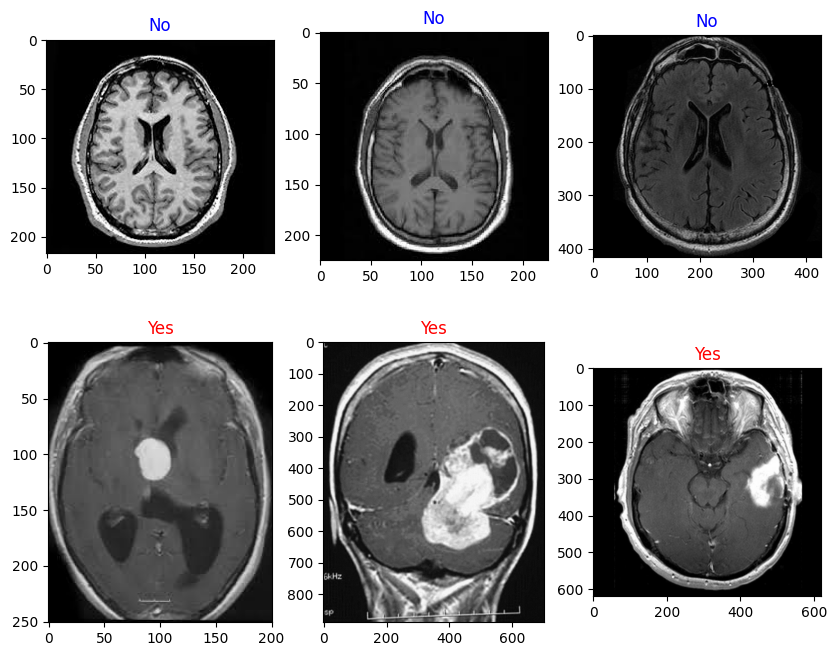

In [ ]:
%matplotlib inline

# Define the path to the dataset
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'

# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()



The preprocess_images function preprocesses a list of images for further analysis or machine learning tasks, specifically for detecting brain tumors. Here's a breakdown of what each step does:

1. Resize Images: It resizes each input image to a fixed size of 224x224 pixels using OpenCV's cv2.resize function.
2. Convert to Grayscale: It converts each resized image to grayscale using cv2.cvtColor function.
3. Apply Gaussian Blur: It applies Gaussian blur to the grayscale image to reduce noise using cv2.GaussianBlur.
4. Thresholding: It thresholds the blurred image to create a binary image, separating the foreground (tumor) from the background. It uses a threshold value of 45 to create the binary image.
5. Noise Removal: It performs morphological operations (erosion followed by dilation) to remove small regions of noise from the binary image.
6. Find Contours: It finds contours in the thresholded image using cv2.findContours function.
7. Extract Largest Contour: It extracts the largest contour from the list of contours found in the image.
8. Find Extreme Points: It finds the extreme points (leftmost, rightmost, topmost, and bottommost) of the largest contour.
9. Crop Image: It crops the original image using the extreme points to focus only on the region containing the brain tumor.
10. Resize Cropped Image: It resizes the cropped image to a fixed size of 224x224 pixels.
11. Append Preprocessed Images: It appends the preprocessed images to a list.
12. Return Preprocessed Images: It returns the preprocessed images as a NumPy array.



In [ ]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [ ]:
# Apply the preprocessing to all the data subsets
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [ ]:
# Transform the subsets to numpy arrays
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

This code snippet plots a 3x3 grid of images from the X_train_pre_vgg dataset, providing a visual representation of the data for analysis or inspection. Each subplot displays a single image, and the entire grid is displayed in a single figure.

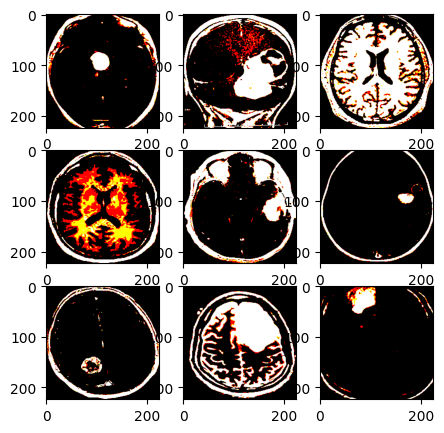

In [ ]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap='gray')
plt.show()

In [ ]:
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras.callbacks import Callback
import time
from keras.preprocessing.image import ImageDataGenerator

This code sets up and trains a CNN model for image classification with data augmentation, learning rate reduction, and early stopping capabilities.
Explanation:

1.Define a CNN model with convolutional layers, pooling layers, and dense layers for image classification.\
2.Compile the model with appropriate loss function, optimizer, and metrics.\
3.Use data augmentation techniques to increase the diversity of training samples.\
4.Create a data generator for generating augmented training data batches.
Define a callback to reduce the learning rate when the validation accuracy plateaus.\
5.Define a callback to stop training when the training accuracy reaches 90%.
Create a data generator for generating validation data batches.\
7.Train the model using the training data generator, validation data generator, and defined callbacks.

In [ ]:
#3 block CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
# Freeze the weights of the pre-trained model
# model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile(
loss='binary_crossentropy',
optimizer=Adam(),
metrics=['accuracy']
)

# Print the summary of the model
model.summary()

# Define the training data generator with necessary data augmentation techniques
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Create the training data generator using the training dataset and the data generator
train_generator = train_datagen.flow(
X_train_pre_vgg,
y_train,
batch_size=32
)

# Define a callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5)

# Define a callback to stop the training when validation accuracy reaches 90%
class StopOnAccuracy(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90:
            print("\nReached 90% accuracy, stopping training...")
            self.model.stop_training = True

# Define the validation data generator with appropriate data preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the validation data generator using the validation dataset and the data generator
val_generator = val_datagen.flow(X_val_pre_vgg, y_val, batch_size=18)

# Train the model using the training data generator, validation data generator and the defined callbacks
history = model.fit(
train_generator,
epochs=50,
validation_data=val_generator,
callbacks=[reduce_lr,StopOnAccuracy()]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

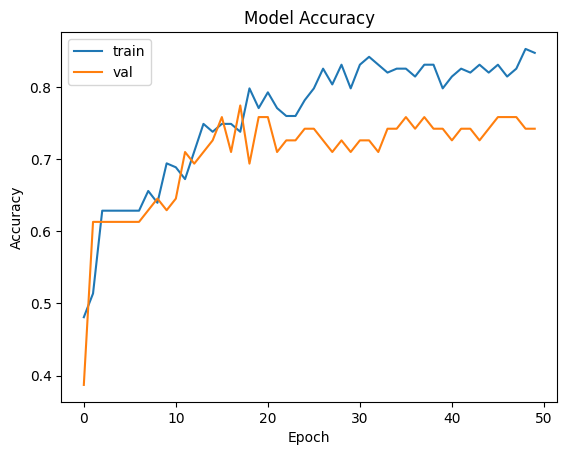

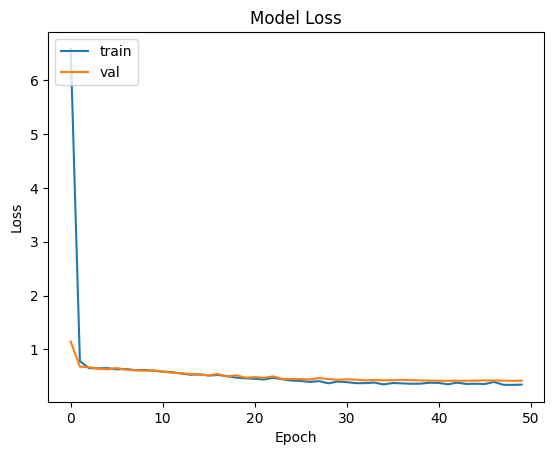

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 643ms/step


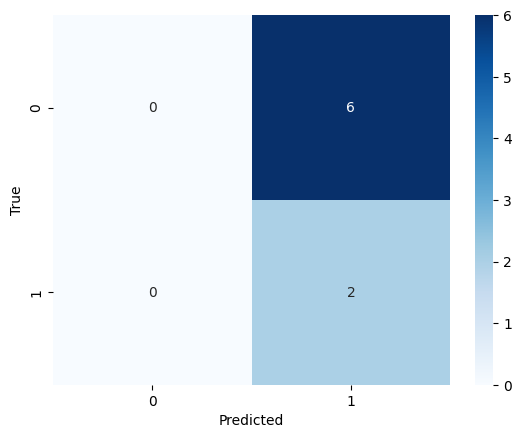

Test accuracy: 0.25


In [ ]:
# Make predictions on X_test_pre
y_pred = model.predict(X_test_pre)
y_pred = np.round(y_pred).astype(int)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', test_accuracy)